In [254]:
import os, sys
import numpy as np
from astropy import units
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### FUV COS spectra

In [5]:
quiescent = Table.read('/Users/arcticfox/Desktop/quiescent_feinstein.txt',format='csv')
flare = Table.read('/Users/arcticfox/Desktop/flareB_feinstein.txt',format='csv')

### HARPS-N spectra

In [13]:
harps_directory = '/Users/arcticfox/Documents/AUMic/harps-n/'
harps_files = np.sort([os.path.join(harps_directory, i) for i in 
                       os.listdir(harps_directory) if i.endswith('.fits')])

In [56]:
harps_data_cube = np.full((3, len(harps_files), 400000), np.nan)

for i in range(len(harps_files)):
    hdu = fits.open(harps_files[i])
    l = len(hdu[1].data[0]['WAVE'])
    harps_data_cube[0][i][:l] = hdu[1].data[0]['WAVE']+0.0
    harps_data_cube[1][i][:l] = hdu[1].data[0]['FLUX']+0.0
    harps_data_cube[2][i][:l] = hdu[1].data[0]['ERR']+0.0
    hdu.close()

In [68]:
# Need to interpolate onto the same wavelength grid to combine
start = np.nanmax(harps_data_cube[0][:,0])

es = np.zeros(len(harps_files))
for i in range(len(harps_files)):
    q = np.isnan(harps_data_cube[0][i])==False
    es[i] = harps_data_cube[0][i][q][-1]
end = np.nanmin(es)

In [103]:
harps_wavelength = np.flip(np.logspace(np.log10(end), np.log10(start), 310000))[1:-1]

In [104]:
harps_spectra = np.zeros((len(harps_files), len(harps_wavelength)))
for i in range(len(harps_files)):
    interp = interp1d(harps_data_cube[0][i], harps_data_cube[1][i])
    harps_spectra[i] = interp(harps_wavelength)
harps_spectra = np.nanmedian(harps_spectra, axis=0)

In [128]:
np.save('harps_spectra.npy', [harps_wavelength, harps_spectra])

### FUSE spectra

In [379]:
fuse_directory = '/Users/arcticfox/Documents/AUMic/fuse/'
fuse_files = np.sort(np.unique([os.path.join(fuse_directory, i) for i in 
                      os.listdir(fuse_directory) if i.endswith('ttagfcal.fit')]))
#fuse_spectra_files = np.array([fuse_files[0],fuse_files[10]])
#fuse_files = np.delete(fuse_files,[0,10])

In [433]:
fuse_wave_cube = np.zeros((4, 44, 30000))
fuse_flux_cube = np.zeros((4, 44, 30000))

tags = ['alif', 'asic', 'blif', 'bsic']

times = np.zeros((4,44,2), dtype='U40')

for j in range(len(tags)):
    ff = np.sort([i for i in fuse_files if tags[j] in i])

    for i in range(len(ff)):
        hdu = fits.open(ff[i])
        t = hdu[0].header['EXPSTART']

        times[j][i][0] = str(Time(hdu[0].header['EXPSTART'], format='mjd').datetime)
        times[j][i][1] = str(Time(hdu[0].header['EXPEND'], format='mjd').datetime)

        fuse_wave_cube[j][i][:len(hdu[1].data['WAVE'])] = hdu[1].data['WAVE']
        fuse_flux_cube[j][i][:len(hdu[1].data['FLUX'])] = hdu[1].data['FLUX']

        hdu.close()

In [464]:
inds = [[0,18],[1,19]]

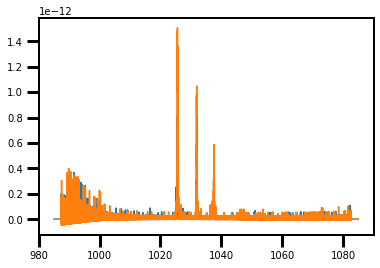

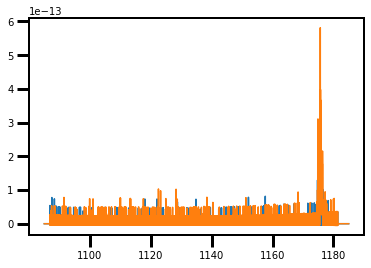

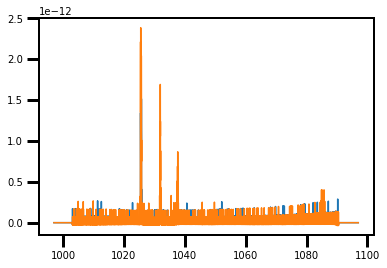

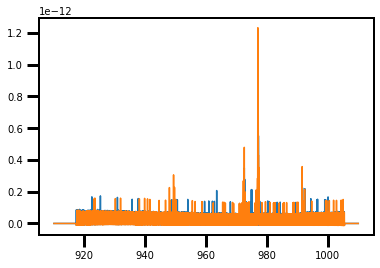

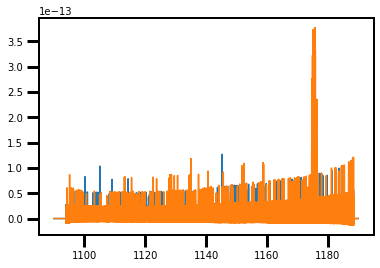

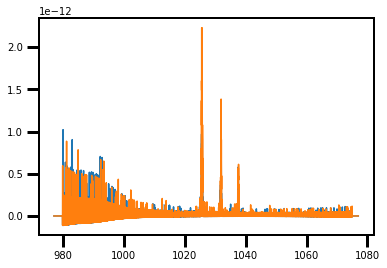

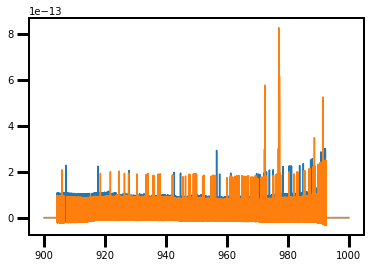

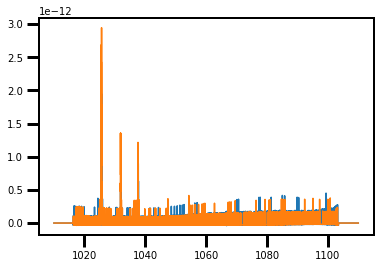

In [527]:
interp_wave = np.zeros((4,4,7700-2))
interp_flux = np.zeros((4,4,7700-2))

for j in range(len(tags)):
    w, f = [], []
    minw, maxw = [], []
    
    for i in range(len(inds)):
        q = fuse_wave_cube[j][inds[i][0]]>0
        plt.plot(fuse_wave_cube[j][inds[i][0]][q], fuse_flux_cube[j][inds[i][0]][q])
        w.append(fuse_wave_cube[j][inds[i][0]][q])
        f.append(fuse_flux_cube[j][inds[i][0]][q])
        
        minw.append(np.nanmin(fuse_wave_cube[j][inds[i][0]][q]))
        maxw.append(np.nanmax(fuse_wave_cube[j][inds[i][0]][q]))
        
        q = fuse_wave_cube[j][inds[i][1]]>0 
        plt.plot(fuse_wave_cube[j][inds[i][1]][q], fuse_flux_cube[j][inds[i][1]][q])
        w.append(fuse_wave_cube[j][inds[i][1]][q])
        f.append(fuse_flux_cube[j][inds[i][1]][q])
        plt.show()
    
        minw.append(np.nanmin(fuse_wave_cube[j][inds[i][1]][q]))
        maxw.append(np.nanmax(fuse_wave_cube[j][inds[i][1]][q]))
    
    neww1 = np.logspace(np.log10(np.nanmax(minw[:2])), 
                        np.log10(np.nanmin(maxw[:2])), 7700)[1:-1]
    neww2 = np.logspace(np.log10(np.nanmax(minw[2:])), 
                        np.log10(np.nanmin(maxw[2:])), 7700)[1:-1]
    
    for i in range(len(w)):
        itrp = interp1d(w[i], f[i])
        if i < 2:
            interp_wave[j][i] = neww1
            interp_flux[j][i] = itrp(neww1)
        else:
            interp_wave[j][i] = neww2
            interp_flux[j][i] = itrp(neww2)

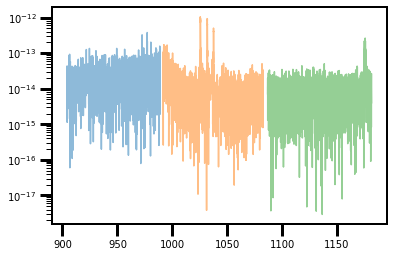

In [565]:
finalw, finalf = np.array([]), np.array([])

for i in [3,0]:
    q = np.nanmean(interp_flux[i][:2],axis=0)>0
    if i == 0:
        cutends = 130
        plt.plot(interp_wave[i][0][q][cutends:], 
                 np.nanmean(interp_flux[i][:2],axis=0)[q][cutends:],
                 alpha=0.5)
        finalw = np.append(finalw, interp_wave[i][0][q][cutends:])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][:2],axis=0)[q][cutends:])
    else:
        cutends=130
        plt.plot(interp_wave[i][0][q][:-cutends], 
                 np.nanmean(interp_flux[i][:2],axis=0)[q][:-cutends],
                 alpha=0.5)
        finalw = np.append(finalw, interp_wave[i][0][q][:-cutends])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][:2],axis=0)[q][:-cutends])    
    if i != 3:
        q = np.nanmean(interp_flux[i][2:],axis=0)>0
        plt.plot(interp_wave[i][2][q], np.nanmean(interp_flux[i][2:],axis=0)[q],alpha=0.5)
        
        finalw = np.append(finalw, interp_wave[i][2][q])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][2:],axis=0)[q])
        
plt.yscale('log')
plt.show()

In [568]:
np.save('fuse_spectra.npy', [finalw, finalf])

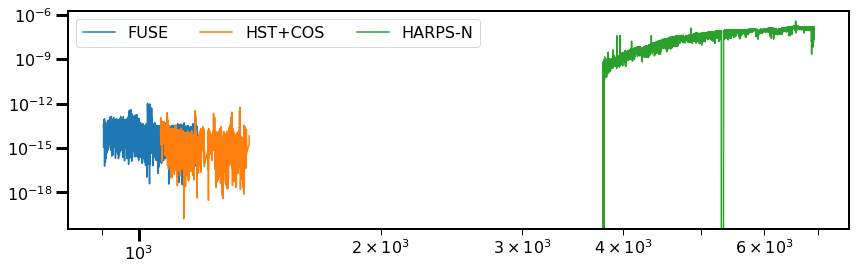

In [849]:
plt.figure(figsize=(14,4))
plt.plot(finalw, finalf, label='FUSE')
q = quiescent['flux_density']>0
plt.plot(quiescent['wavelength_AA'][q], quiescent['flux_density'][q], label='HST+COS')
plt.plot(harps_wavelength, harps_spectra/10e10, label='HARPS-N')
plt.legend(ncol=3)
plt.yscale('log')
plt.xscale('log')

### XMM spectra

In [685]:
plt.rcParams['font.size'] = 16

In [822]:
obsIDs = ['obsID0822740401', 'obsID0822740601']# 'obsID0822740501']
d = 0
xmm_directory = '/Users/arcticfox/Documents/AUMic/xmm_spectra/{0}_{1}'

xmm_lc_files = np.sort([os.path.join(xmm_directory.format(obsIDs[d], 'lcs'),i) for i in 
                        os.listdir(xmm_directory.format(obsIDs[d],'lcs'))
                     if i.endswith('FTZ') and 'TIMESR' in i])
xmm_sp_files = np.sort([os.path.join(xmm_directory.format(obsIDs[d],'spectra'),i) for i in 
                        os.listdir(xmm_directory.format(obsIDs[d],'spectra'))
                     if i.endswith('FTZ') and 'BGSPEC' in i])

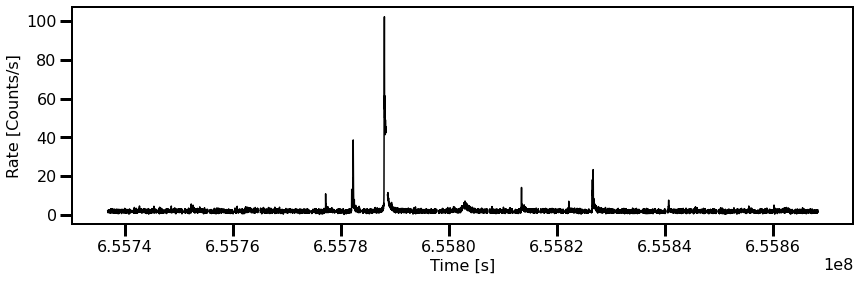

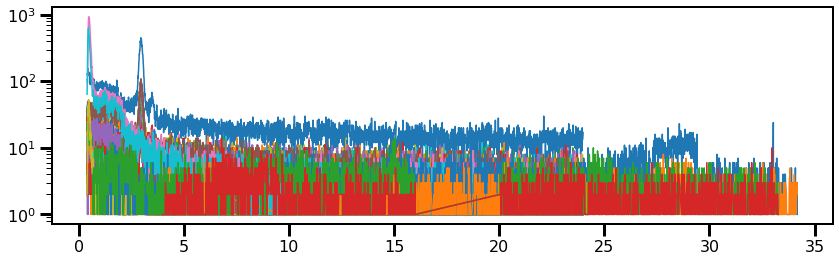

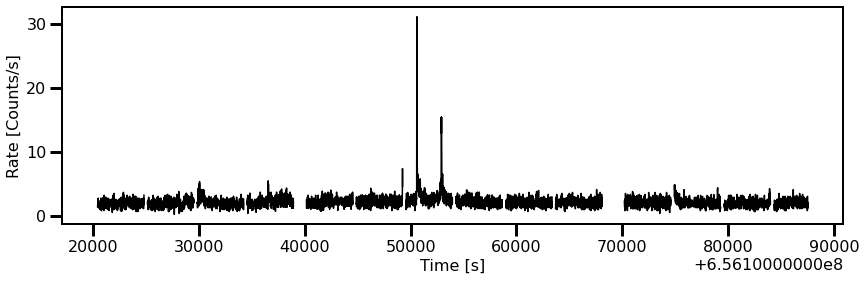

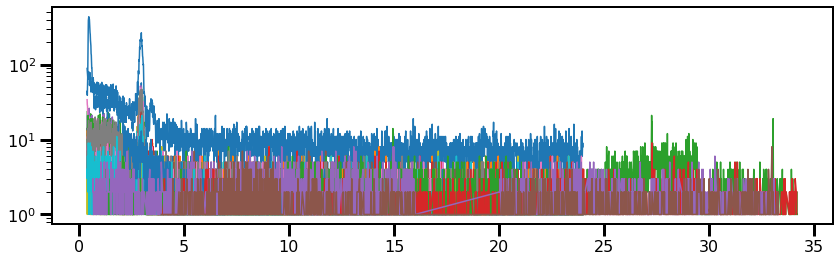

In [831]:
lc_tmid = np.zeros((len(obsIDs), 100, 2))
tmid_spec = np.zeros((len(obsIDs),100,2))
lc_time, lc_rate = np.zeros(len(obsIDs), dtype=np.ndarray), np.zeros(len(obsIDs), dtype=np.ndarray)
counts, channel = np.zeros(len(obsIDs), dtype=np.ndarray), np.zeros(len(obsIDs), dtype=np.ndarray)

for d in range(len(obsIDs)):
    fig=plt.figure(figsize=(14,4))
    fig.set_facecolor('w')
    
    xmm_lc_files = np.sort([os.path.join(xmm_directory.format(obsIDs[d], 'lcs'),i) for i in 
                        os.listdir(xmm_directory.format(obsIDs[d],'lcs'))
                     if i.endswith('FTZ') and 'TIMESR' in i])
    
    xmm_sp_files = np.sort([os.path.join(xmm_directory.format(obsIDs[d],'spectra'),i) for i in 
                        os.listdir(xmm_directory.format(obsIDs[d],'spectra'))
                     if i.endswith('FTZ') and 'BGSPEC' in i])
    
    for i in range(len(xmm_lc_files)):
        hdu = fits.open(xmm_lc_files[i])

        plt.plot(hdu[1].data['TIME'], hdu[1].data['RATE'],'k')
        
        sr = Time(hdu[1].header['MJDREF'],format='mjd')+(hdu[1].header['TSTART']*units.s)
        sp = Time(hdu[1].header['MJDREF'],format='mjd')+(hdu[1].header['TSTOP']*units.s)
        
        lc_time[d] = np.append(lc_time[d], hdu[1].data['TIME'])
        lc_rate[d] = np.append(lc_rate[d], hdu[1].data['RATE'])
        lc_tmid[d][i] = [sr.value, sp.value]
        
        hdu.close()
    plt.xlabel('Time [s]')
    plt.ylabel('Rate [Counts/s]')
    plt.show()
    
    
    fig=plt.figure(figsize=(14,4))
    bad = np.array([], dtype=int)
    for i in range(len(xmm_sp_files)):
        spec = fits.open(xmm_sp_files[i])
        
        if i == 0:
            temp_chan = np.zeros((len(xmm_sp_files), len(spec[1].data['CHANNEL'])))
            temp_cnts  = np.zeros((len(xmm_sp_files), len(spec[1].data['COUNTS'])))
            
        try:
            temp_chan[i] = spec[1].data['CHANNEL']/100
            temp_cnts[i]  = spec[1].data['COUNTS']
        except:
            bad = np.append(bad, i)
            pass
        q = spec[1].data['COUNTS'] > 0
        plt.plot(spec[1].data['CHANNEL'][q]/100, spec[1].data['COUNTS'][q])
        spec.close()
    plt.yscale('log')
    plt.show()
    channel[d] = np.delete(temp_chan, bad, axis=0)
    counts[d]  = np.delete(temp_cnts, bad, axis=0)
#plt.savefig('/Users/arcticfox/Desktop/xmm_lc.png', dpi=250, rasterize=True, bbox_inches='tight')

In [790]:
len(xmm_sp_files)/len(xmm_lc_files)

3.357142857142857

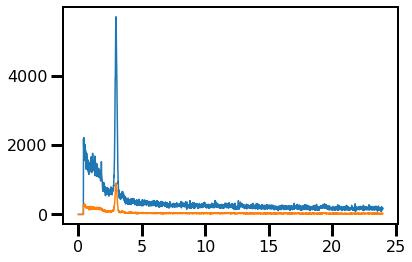

In [838]:
plt.plot(np.nanmedian(channel[0],axis=0), np.nansum(counts[0],axis=0))
plt.plot(np.nanmedian(channel[1],axis=0), np.nansum(counts[1],axis=0))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


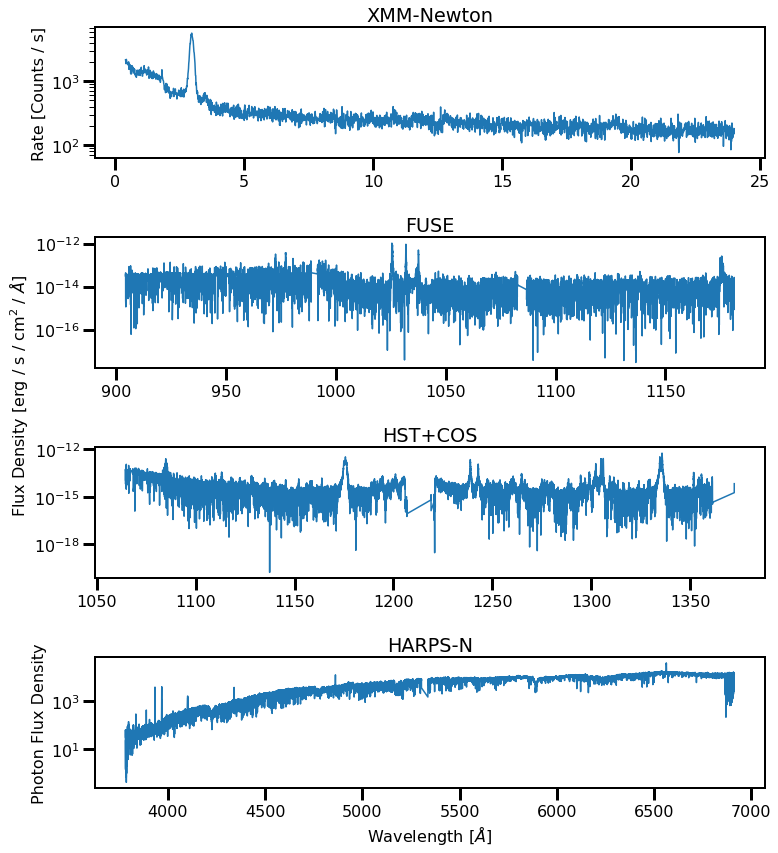

In [880]:
fig,axes=plt.subplots(nrows=4,figsize=(12,14))
fig.set_facecolor('w')
axes=axes.reshape(-1)
axes[1].plot(finalw, finalf, label='FUSE')
axes[1].set_title('FUSE')

q = quiescent['flux_density']>0
axes[2].plot(quiescent['wavelength_AA'][q], quiescent['flux_density'][q])
axes[2].set_title('HST+COS')
axes[2].set_ylabel('Flux Density [erg / s / cm$^2$ / $\AA$]', y=1.4)

q = harps_spectra > 0
axes[3].plot(harps_wavelength[q], harps_spectra[q])
axes[3].set_title('HARPS-N')
axes[3].set_xlabel('Wavelength [$\AA$]')
axes[3].set_ylabel('Photon Flux Density')

q = np.nansum(counts[0],axis=0)>0
axes[0].plot(np.nanmedian(channel[0],axis=0)[q], 
             np.nansum(counts[0],axis=0)[q])
axes[0].set_title('XMM-Newton')
axes[0].set_ylabel('Rate [Counts / s]')

for i in range(4):
    axes[i].set_yscale('log')
    #axes[i].xscale('log')
plt.subplots_adjust(hspace=0.6)
plt.savefig('/Users/arcticfox/Desktop/panchromatic.png', dpi=250,
            rasterize=True, bbox_inches='tight')

In [874]:
hdu = fits.open(harps_files[0])

In [875]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              5009216 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM1  = '313076D '                                                            
TTYPE2  = 'FLUX    '                                                            
TFORM2  = '313076E '                                                            
TTYPE3  = 'ERR     '        